In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import csv
import random


In [ ]:
import zipfile

from google.colab import drive
drive.mount('/content/drive')

# 解壓縮檔案
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/card_classification/Card Classified.zip'
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall('/content/card_dataset')
zip_ref.close()

# 檢查檔案是否已解壓縮
print(os.listdir('/content/card_dataset'))

Mounted at /content/drive
['Card Classified(13) - Studend']


In [ ]:
PATH_train="/content/card_dataset/Card Classified(13) - Studend/Train Dataset"
TRAIN =Path(PATH_train)
batch_size = 128
LR = 0.0001   #learning rate
n_epochs = 20



transform1 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.GaussianBlur(7, sigma=(9, 15)),
                                 transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),
                                 transforms.ToTensor()])

transform2 = transforms.Compose([transforms.Resize((224,224)),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomResizedCrop([224,224], scale=(0.9, 1.0),
                                                              ratio=(0.75, 1.3333333333333333), interpolation=2),
                                 transforms.RandomRotation([-180,180], expand=True, fill=None),
                                 transforms.GaussianBlur(7, sigma=(9, 15)),
                                 transforms.Resize((224,224)),
                                 transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),

                                 transforms.ToTensor()
                                  ])
mytransform= transforms.RandomChoice([transform1, transform2])
#==================================================
train_data = datasets.ImageFolder(TRAIN, transform = mytransform)
#切分70%當作訓練集  30%當作驗證集
train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])
#Dataloader可以用Batch的方式訓練
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,shuffle=True)


觀察圖片transform後的樣子，第一次請和上面transform一起跑，之後若有更改transform才要再跑上面，否則不需要，可以多跑幾次這個，每次結果不同因為很多transform的參數有設隨機



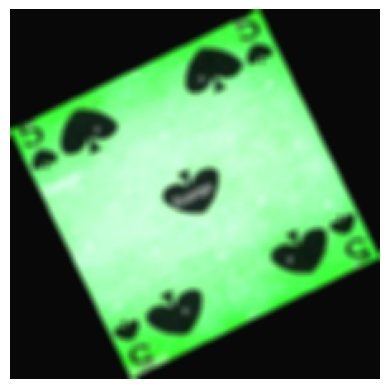

In [ ]:
#train_data = datasets.ImageFolder(TRAIN, transform = mytransform)

from torchvision.transforms import ToPILImage

# 載入train_data 第一張圖片進行顯示  (train_data已經transform過)
example_img= train_data[0][0] #圖片tensor

# 將 Tensor 轉換回 PIL.Image 物件
to_pil = ToPILImage()
example_img_pil = to_pil(example_img)
#transformed_img = mytransform(example_img_pil)

# 把通道順序調整為 (height, width, channels)
transformed_img = example_img.permute(1, 2, 0)

# 將圖片顯示出來
plt.imshow(transformed_img)
plt.axis('off')
plt.show()

In [ ]:
# 使用預訓練模型RESNET50作為卡牌分類的主體
model = models.resnet50(pretrained=True)

# 將模型的最後一層改為全連接層    輸出為14個類別
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14)

# 將模型轉移到GPU上 進行訓練（如果有可用的話）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定義loss function
criterion = nn.CrossEntropyLoss()

# 定義optimizer為Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 訓練模型
train_losses = []
valid_losses = []
train_accuracy = []  # 新增訓練集正確率的儲存
valid_accuracy = []
for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    correct_train = 0  # 新增訓練集正確預測的計數器
    correct_valid = 0

    # 訓練模型
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        _, predicted = torch.max(output.data, 1)
        correct_train += (predicted == target).sum().item()  # 計算正確預測的數量

    # 計算訓練集損失值和正確率
    train_loss = train_loss/len(train_loader.dataset)
    train_losses.append(train_loss)
    accuracy_train = 100 * correct_train / len(train_loader.dataset)  # 計算正確率
    train_accuracy.append(accuracy_train)

    # 計算驗證集損失值和正確率
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            _, predicted = torch.max(output.data, 1)
            correct_valid += (predicted == target).sum().item()

    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    accuracy_valid = 100 * correct_valid / len(valid_loader.dataset)
    valid_accuracy.append(accuracy_valid)

    # 輸出當前epoch的loss和accuracy
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(epoch+1, train_loss, accuracy_train, valid_loss, accuracy_valid))
# 保存 train_losses
with open('train_losses.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in train_losses:
        writer.writerow([value])
# 保存 train_accuracy
with open('train_accuracy.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in train_accuracy:
        writer.writerow([value])
# 保存 valid_losses
with open('valid_losses.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in valid_losses:
        writer.writerow([value])
# 保存 valid_accuracy
with open('valid_accuracy.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in valid_accuracy:
        writer.writerow([value])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 351MB/s]


Epoch: 1 	Training Loss: 1.745584 	Training Accuracy: 40.84% 	Validation Loss: 1.279725 	Validation Accuracy: 55.24%
Epoch: 2 	Training Loss: 0.993554 	Training Accuracy: 68.59% 	Validation Loss: 0.871185 	Validation Accuracy: 72.16%
Epoch: 3 	Training Loss: 0.704303 	Training Accuracy: 77.66% 	Validation Loss: 0.708449 	Validation Accuracy: 76.88%
Epoch: 4 	Training Loss: 0.543499 	Training Accuracy: 83.34% 	Validation Loss: 0.611545 	Validation Accuracy: 80.38%
Epoch: 5 	Training Loss: 0.416641 	Training Accuracy: 87.03% 	Validation Loss: 0.553562 	Validation Accuracy: 82.39%
Epoch: 6 	Training Loss: 0.340009 	Training Accuracy: 89.64% 	Validation Loss: 0.517310 	Validation Accuracy: 84.18%
Epoch: 7 	Training Loss: 0.311188 	Training Accuracy: 90.12% 	Validation Loss: 0.471063 	Validation Accuracy: 85.14%
Epoch: 8 	Training Loss: 0.265026 	Training Accuracy: 91.40% 	Validation Loss: 0.417991 	Validation Accuracy: 87.76%
Epoch: 9 	Training Loss: 0.241078 	Training Accuracy: 92.65% 	Va

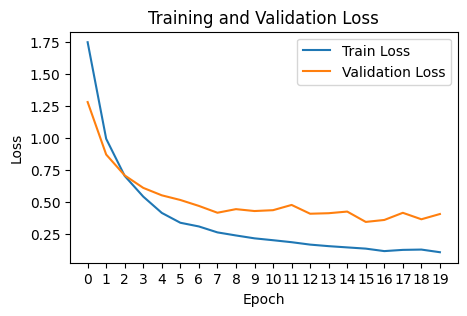

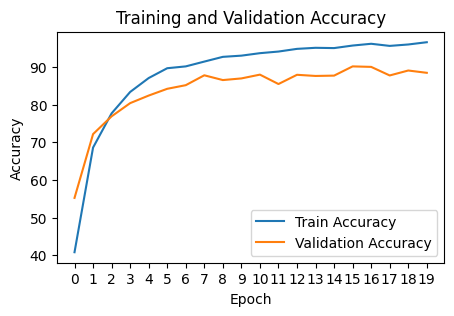

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 讀取 train_losses.csv 和 valid_losses.csv 文件
train_loss = pd.read_csv('train_losses.csv', header=None, names=['value'])
val_loss = pd.read_csv('valid_losses.csv', header=None, names=['value'])

# 讀取 train_accuracy.csv 和 valid_accuracy.csv 文件
train_acc = pd.read_csv('train_accuracy.csv', header=None, names=['value'])
val_acc = pd.read_csv('valid_accuracy.csv', header=None, names=['value'])

x_ticks = np.linspace(0, len(train_loss)-1, 20, dtype=int)

# 畫出訓練和驗證的損失曲線
plt.subplots(figsize=(5, 3))
plt.plot(train_loss.index, train_loss['value'], label='Train Loss')
plt.plot(val_loss.index, val_loss['value'], label='Validation Loss')
plt.xticks(x_ticks)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 畫出訓練、驗證的準確率曲線
plt.subplots(figsize=(5, 3))
plt.plot(train_acc.index, train_acc['value'], label='Train Accuracy')
plt.plot(val_acc.index, val_acc['value'], label='Validation Accuracy')
plt.xticks(x_ticks)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# 定義測試集的路徑
PATH_test = "/content/card_dataset/Card Classified(13) - Studend/Test Dataset"
TEST = Path(PATH_test)

# 設定預處理的方式
mytransform = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.ToTensor()])

# 取得所有的測試檔案名稱
test_filenames = sorted(os.listdir(TEST))

# 取得所有的測試檔案名稱並依據數字部分排序
test_filenames = sorted(os.listdir(TEST), key=lambda x: int(x.split('.')[0].split('_')[1]))

# 定義自定義 label 的對應關係
label_mapping = {
    0: "1",
    1: "8",
    2: "5",
    3: "4",
    4: "11",
    5: "0",
    6: "13",
    7: "9",
    8: "12",
    9: "7",
    10: "6",
    11: "10",
    12: "3",
    13: "2",
    # ... 其他 label 的對應關係 ...
}

# 預測每一張圖片
model.eval() # 進入評估模式
result = [] # 存放預測結果
with torch.no_grad():
    for filename in tqdm(test_filenames):
        img_path = TEST / filename
        img = Image.open(img_path)
        img = mytransform(img)
        img = img.unsqueeze(0) # 加上 batch 的維度
        img = img.to(device)
        #=================
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)

        # 使用自定義的 label 對應關係
        predicted_label = label_mapping[predicted.item()]
        result.append(predicted_label)

# 將預測結果寫成 csv 檔案
df = pd.DataFrame({'img_name': test_filenames, 'Label': result})
df.to_csv('prediction.csv', index=False)


<ipython-input-7-324c4930c5f3>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm(test_filenames):


  0%|          | 0/270 [00:00<?, ?it/s]

In [ ]:
from google.colab import files


# 下載預測結果的 CSV 檔案 到本機
files.download('prediction.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 定義保存模型權重的路徑和檔案名
save_path = 'w007.pth'

# 保存模型權重
torch.save(model.state_dict(), save_path)